In [ ]:
pip install qutip


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import qutip as qt
from mpl_toolkits.mplot3d import Axes3D

In [ ]:

def jaynes_cummings_dynamics(g1, kappa=0, gamma=0, detuning=0, n=0, non_linear=False):
    """
    Simulates the Jaynes-Cummings model using QuTiP.

    Parameters:
    - g1: Coupling strength.
    - kappa: Cavity decay rate.
    - gamma: Atomic decay rate.
    - detuning: Frequency detuning.
    - n: Average thermal photon number.
    - non_linear: If True, applies nonlinear corrections.

    Returns:
    - Plots of cavity and atomic occupation probabilities.
    - Power spectrum.
    """

    g = 2 * np.pi * g1
    omega_c_base = 2 * np.pi * 1
    omega_a_base = 2 * np.pi * 1

    gamma_phi = 0.001  # Dephasing rate

    if non_linear:
        omega_c = omega_c_base + detuning + 0.1 * g**2
        omega_a = omega_a_base + 0.1 * g**2
    else:
        omega_c = omega_c_base + detuning
        omega_a = omega_a_base

    # Operators
    N = 4  # Cavity states
    a = qt.tensor(qt.destroy(N), qt.qeye(2))
    sm = qt.tensor(qt.qeye(N), qt.destroy(2))

    c_ops = [
        np.sqrt(kappa * (1 + n)) * a, np.sqrt(kappa * n) * a.dag(),
        np.sqrt(gamma) * sm,
        np.sqrt(gamma_phi) * qt.tensor(qt.qeye(N), qt.sigmaz())
    ]

    H = omega_c * a.dag() * a + omega_a * sm.dag() * sm + g * (a.dag() * sm + a * sm.dag())

    # Initial state
    psi0 = qt.tensor(qt.basis(N, 0), qt.basis(2, 1))

    # Time evolution
    t_list = np.linspace(0, 25, 1000)
    result = qt.mesolve(H, psi0, t_list, c_ops, [a.dag() * a, sm.dag() * sm])

    # Plot Occupation Probabilities
    plt.figure(figsize=(8, 4))
    plt.plot(t_list, result.expect[0], label="Cavity")
    plt.plot(t_list, result.expect[1], label="Atom")
    plt.xlabel('Time (sec)')
    plt.ylabel('Occupation Probability')
    title = f'Jaynes-Cummings Dynamics: g={g1}, kappa={kappa}, gamma={gamma}, Detuning={detuning}, n={n}'
    plt.title(title + (", Non-linear" if non_linear else ""))
    plt.legend()
    plt.show()

    # Compute Correlation Function and Spectrum
    tlist = np.linspace(0, 100, 5000)
    corr = qt.correlation_2op_1t(H, None, tlist, c_ops, a.dag(), a)
    wlist1, spec1 = qt.spectrum_correlation_fft(tlist, corr)

    wlist2 = np.linspace(0.25, 1.75, 200) * 2 * np.pi
    spec2 = qt.spectrum(H, wlist2, c_ops, a.dag(), a)

    # Plot Power Spectrum
    plt.figure(figsize=(8,4))
    plt.plot(wlist1 / (2 * np.pi), spec1, 'b', lw=2, label='eseries method')
    plt.plot(wlist2 / (2 * np.pi), spec2, 'r--', lw=2, label='me+fft method')
    plt.xlabel('Frequency (meV)')
    plt.ylabel('Power Spectrum (arb. units)')
    plt.title(f'Vacuum Rabi Splitting: g={g1}, kappa={kappa}, gamma={gamma}, Detuning={detuning}, n={n}')
    plt.legend()
    plt.show()

/usr/local/lib/python3.11/dist-packages/qutip/solver/solver_base.py:576: FutureWarning: e_ops will be keyword only from qutip 5.3 for all solver
  warnings.warn(


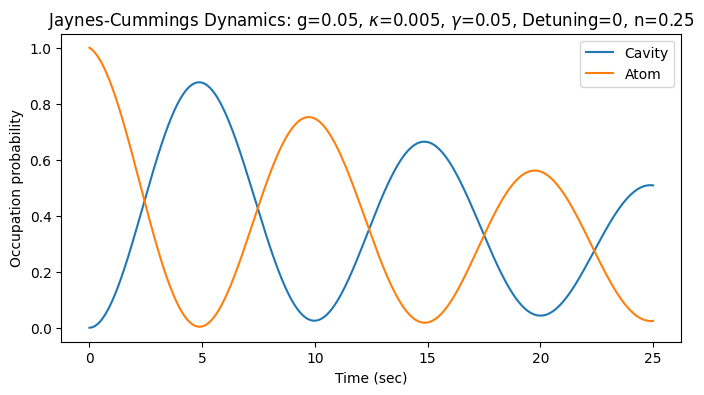

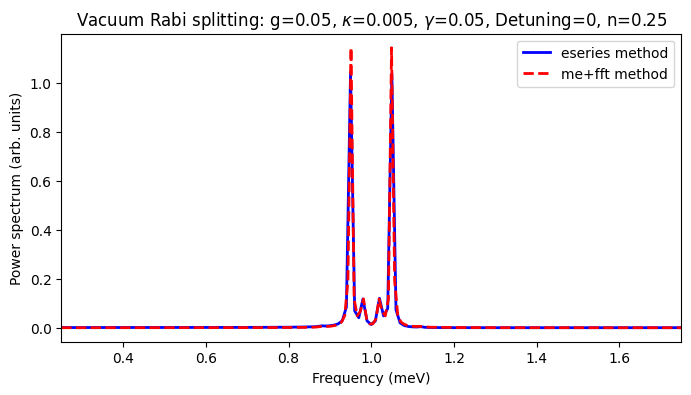

In [12]:
jaynes_cummings_dynamics(0.05,kappa=0.005,gamma=0.05,detuning=0, n=0.25, non_linear=False)

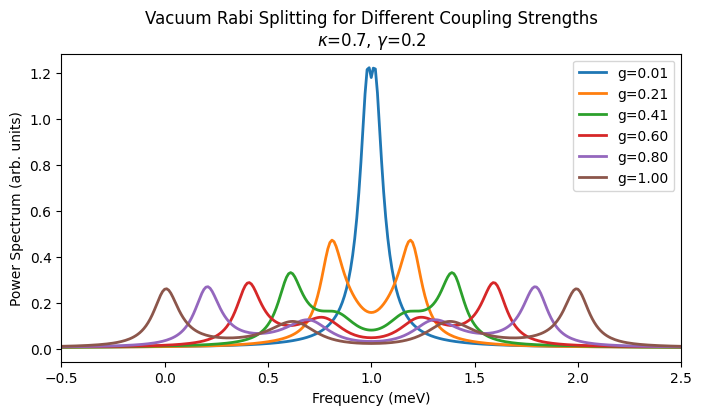

In [ ]:

def power_spectrum_vs_coupling(N=15, wc=2*np.pi, wa=2*np.pi, kappa=0.7, gamma=0.2, n_th=0.25, g_values=None):
    """
    Computes and plots the power spectrum for different Jaynes-Cummings coupling strengths.

    Parameters:
    - N: Number of cavity Fock states
    - wc: Cavity frequency (in 2π units)
    - wa: Atom frequency (in 2π units)
    - kappa: Cavity dissipation rate
    - gamma: Atomic dissipation rate
    - n_th: Thermal photon number (average)
    - g_values: List or numpy array of coupling strengths to iterate over

    Returns:
    - Plot of power spectra for different coupling strengths
    """

    if g_values is None:
        g_values = np.linspace(0.01, 1.0, 6)  # Default coupling strengths

    tlist = np.linspace(0, 100, 5000)
    wlist2 = np.linspace(0.25, 1.75, 200) * 2 * np.pi

    plt.figure(figsize=(8, 4))

    for g_strength in g_values:
        g = g_strength * 2 * np.pi

        # Define the Jaynes-Cummings Hamiltonian
        a = qutip.tensor(qutip.destroy(N), qutip.qeye(2))
        sm = qutip.tensor(qutip.qeye(N), qutip.destroy(2))
        H = wc * a.dag() * a + wa * sm.dag() * sm + g * (a.dag() * sm + a * sm.dag())

        # Define collapse operators
        c_ops = [
            np.sqrt(kappa * (1 + n_th)) * a,
            np.sqrt(kappa * n_th) * a.dag(),
            np.sqrt(gamma) * sm,
        ]

        # Compute correlation function and spectrum
        corr = qutip.correlation_2op_1t(H, None, tlist, c_ops, a.dag(), a)
        wlist1, spec1 = qutip.spectrum_correlation_fft(tlist, corr)

        plt.plot(wlist1 / (2 * np.pi), spec1, lw=2, label=f'g={g_strength:.2f}')

    plt.legend()
    plt.xlabel('Frequency (meV)')
    plt.ylabel('Power Spectrum (arb. units)')
    plt.title(f'Vacuum Rabi Splitting for Different Coupling Strengths\n$\\kappa$={kappa}, $\\gamma$={gamma}')
    plt.xlim(-0.5, 2.5)
    plt.show()

# Run the function when executed as a script
if __name__ == "__main__":
    power_spectrum_vs_coupling()

In [ ]:

def wigner_2d_dynamics(g1, kappa=0, gamma=0, detuning=0, n=0, N=15, times=[0, 5, 10, 15, 20]):
    """
    Computes and plots the 2D Wigner function for the Jaynes-Cummings model.

    Parameters:
    - g1: Coupling strength
    - kappa: Cavity decay rate
    - gamma: Atomic decay rate
    - detuning: Frequency detuning
    - n: Thermal photon number
    - N: Number of cavity states
    - times: List of time steps for visualization
    """

    g = 2 * np.pi * g1
    wc = wa = 2 * np.pi * 1  # Base frequencies

    # Define operators
    a = qt.tensor(qt.destroy(N), qt.qeye(2))
    sm = qt.tensor(qt.qeye(N), qt.destroy(2))

    # Define Hamiltonian
    H = wc * a.dag() * a + wa * sm.dag() * sm + g * (a.dag() * sm + a * sm.dag())

    # Define collapse operators
    c_ops = [
        np.sqrt(kappa * (1 + n)) * a,
        np.sqrt(kappa * n) * a.dag(),
        np.sqrt(gamma) * sm,
    ]

    # Solve the system
    psi0 = qt.tensor(qt.basis(N, 0), qt.basis(2, 1))
    t_list = np.linspace(0, 25, 100)
    result = qt.mesolve(H, psi0, t_list, c_ops, [])

    # Define phase space grid
    xvec = np.linspace(-5, 5, 200)

    # Create figure with subplots (VERTICAL layout)
    num_plots = len(times)
    fig, axes = plt.subplots(num_plots, 1, figsize=(8, 8 * num_plots), constrained_layout=False)

    if num_plots == 1:
        axes = [axes]  # Ensure axes is always a list for consistency

    # Generate Wigner functions and plot
    for i, t in enumerate(times):
        idx = np.argmin(np.abs(t_list - t))  # Find closest time index
        rho_cavity = result.states[idx].ptrace(0)  # Trace out atomic state
        W = qt.wigner(rho_cavity, xvec, xvec)

        ax = axes[i]
        contour = ax.contourf(xvec, xvec, W, 100, cmap='RdBu')

        ax.set_title(f't = {t}')
        ax.set_xlabel('Re[$\\alpha$]')
        ax.set_ylabel('Im[$\\alpha$]')

        # Add a colorbar for each subplot
        cbar = fig.colorbar(contour, ax=ax, fraction=0.05, pad=0.04)
        cbar.ax.tick_params(labelsize=8)  # Make colorbar labels smaller if needed

    # Adjust vertical spacing between plots
    plt.subplots_adjust(hspace=0.5)  # Increases vertical space between subplots
    plt.show()


def wigner_3d_dynamics(g1, kappa=0, gamma=0, detuning=0, n=0, N=15, times=[0, 5, 10, 15, 20]):
    """
    Computes and plots multiple 3D Wigner functions in a single figure.

    Parameters:
    - g1: Coupling strength
    - kappa: Cavity decay rate
    - gamma: Atomic decay rate
    - detuning: Frequency detuning
    - n: Thermal photon number
    - N: Number of cavity states
    - times: List of time steps for visualization
    """

    g = 2 * np.pi * g1
    wc = wa = 2 * np.pi * 1  # Base frequencies

    # Define operators
    a = qt.tensor(qt.destroy(N), qt.qeye(2))
    sm = qt.tensor(qt.qeye(N), qt.destroy(2))

    # Define Hamiltonian
    H = wc * a.dag() * a + wa * sm.dag() * sm + g * (a.dag() * sm + a * sm.dag())

    # Define collapse operators
    c_ops = [
        np.sqrt(kappa * (1 + n)) * a,
        np.sqrt(kappa * n) * a.dag(),
        np.sqrt(gamma) * sm,
    ]

    # Solve the system
    psi0 = qt.tensor(qt.basis(N, 0), qt.basis(2, 1))
    t_list = np.linspace(0, 25, 100)
    result = qt.mesolve(H, psi0, t_list, c_ops, [])

    # Define phase space grid
    xvec = np.linspace(-5, 5, 50)
    X, Y = np.meshgrid(xvec, xvec)

    num_plots = len(times)

    # OPTION 1: Horizontal layout (1 row)
    #fig, axes = plt.subplots(1, num_plots, figsize=(num_plots * 5, 5), subplot_kw={'projection': '3d'})

    # OPTION 2: Vertical layout (1 column)
    fig, axes = plt.subplots(num_plots, 1, figsize=(10, num_plots * 10), subplot_kw={'projection': '3d'})

    if num_plots == 1:
        axes = [axes]  # Make sure axes is iterable when there's only one plot

    for i, t in enumerate(times):
        idx = np.argmin(np.abs(t_list - t))
        rho_cavity = result.states[idx].ptrace(0)
        W = qt.wigner(rho_cavity, xvec, xvec)

        surf = axes[i].plot_surface(X, Y, W, rstride=1, cstride=1, cmap='RdBu', edgecolor='none')

        axes[i].set_xlabel('Re[$\\alpha$]')
        axes[i].set_ylabel('Im[$\\alpha$]')
        axes[i].set_zlabel('Wigner function')
        axes[i].set_title(f't={t}')
        fig.colorbar(surf, shrink=0.5, aspect=5)

    plt.tight_layout()
    plt.show()

/usr/local/lib/python3.11/dist-packages/qutip/solver/solver_base.py:576: FutureWarning: e_ops will be keyword only from qutip 5.3 for all solver
  warnings.warn(


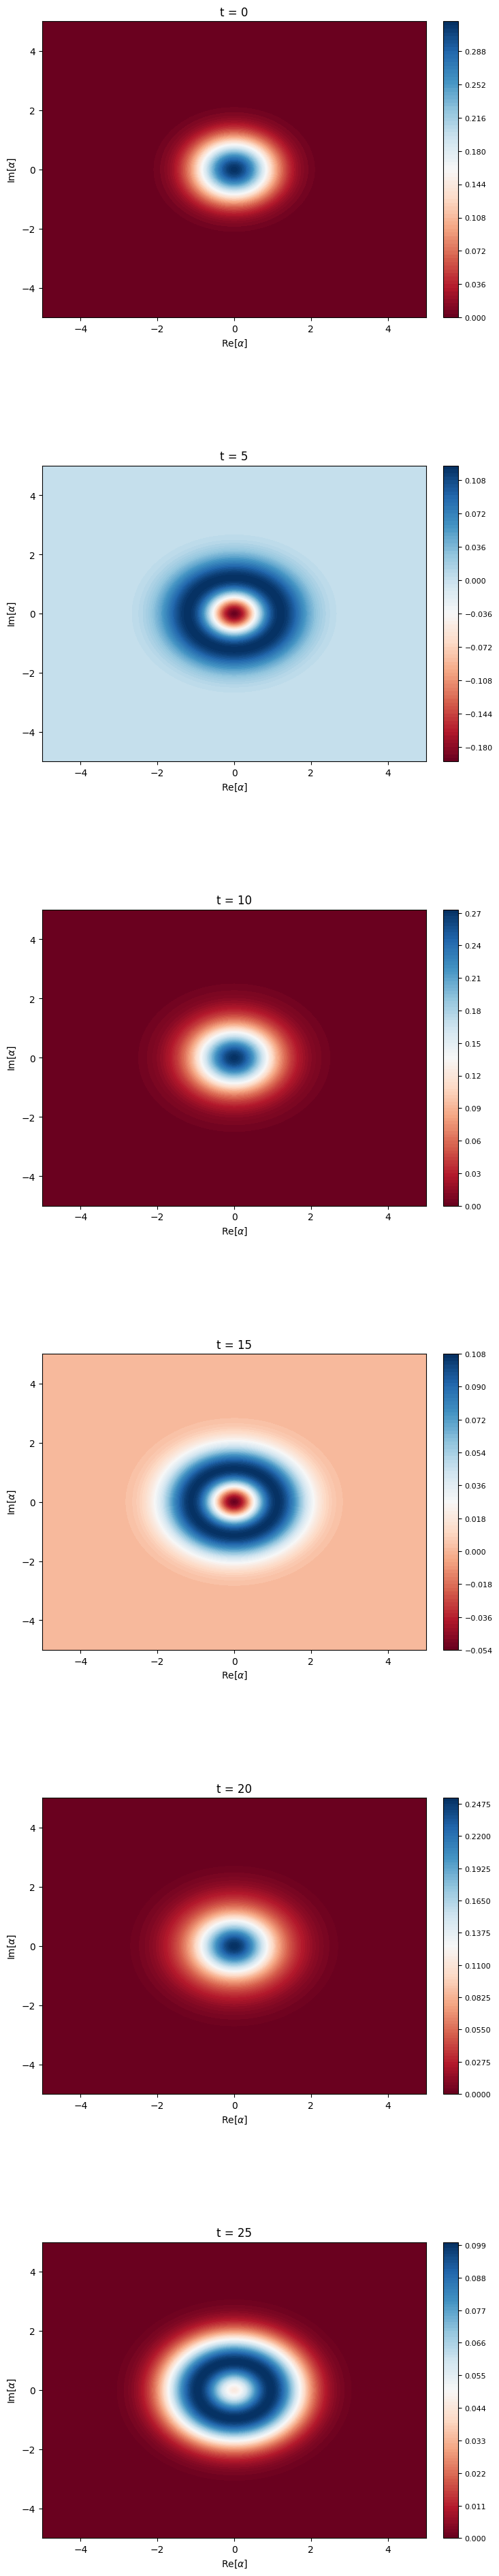

In [7]:
wigner_2d_dynamics(g1=0.05, kappa=0.005, gamma=0.05, detuning=0, n=2, N=15, times=[0, 5, 10, 15, 20, 25])

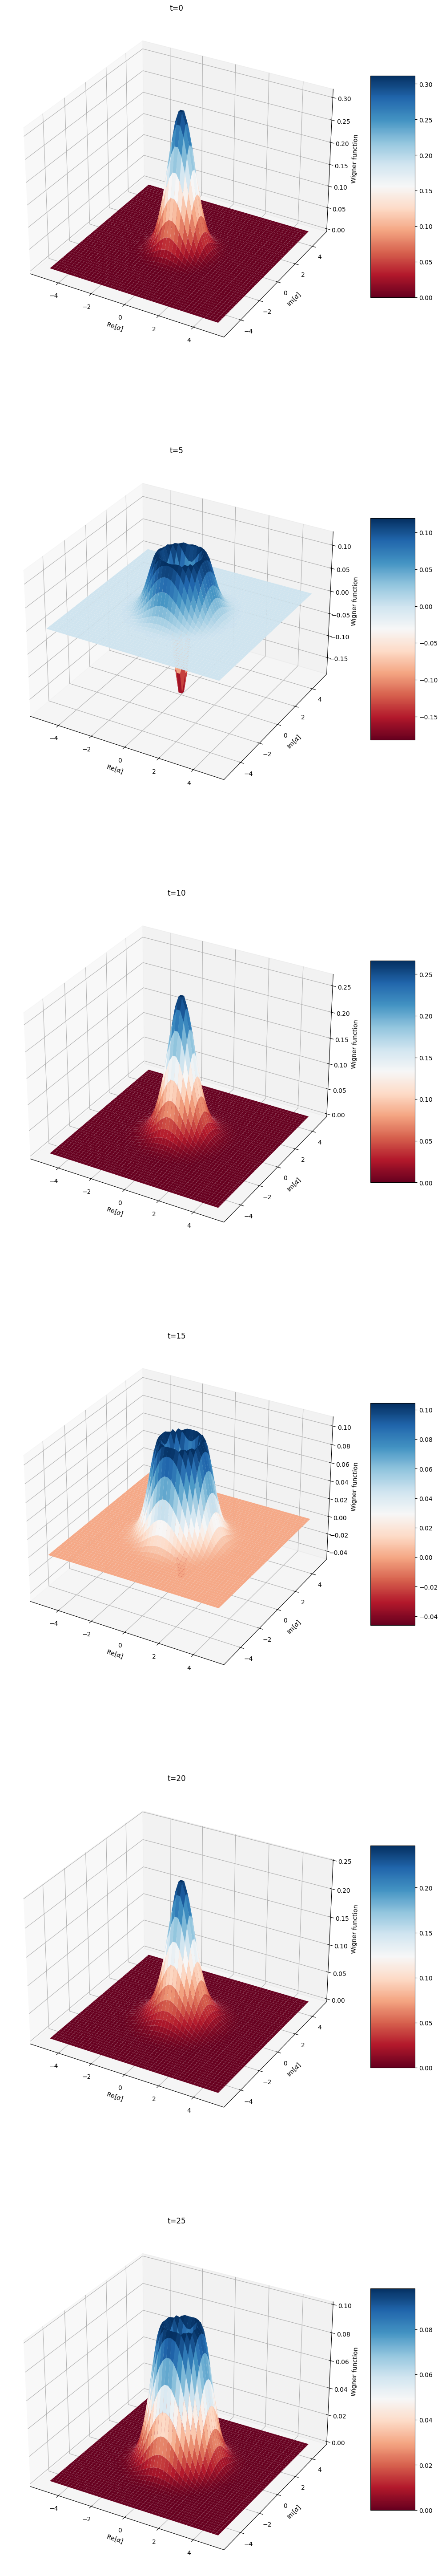

In [8]:
wigner_3d_dynamics(g1=0.05, kappa=0.005, gamma=0.05, detuning=0, n=2, N=15, times=[0, 5, 10, 15, 20, 25])

In [ ]:

def bloch_dynamics_snapshots(g1, kappa=0, gamma=0, detuning=0, n=0, N=15, timesteps=100, snapshot_times=[0, 5, 10, 15, 20, 25]):
    """
    Plots Bloch sphere snapshots at different time steps for Jaynes-Cummings model.

    Parameters:
    - g1: Coupling strength
    - kappa: Cavity decay rate
    - gamma: Atomic decay rate
    - detuning: Frequency detuning
    - n: Thermal photon number
    - N: Number of cavity states
    - timesteps: Number of time steps for visualization
    - snapshot_times: Specific times to visualize the state

    Returns:
    - Multiple Bloch spheres showing state evolution at different times.
    """

    g = 2 * np.pi * g1
    wc = wa = 2 * np.pi * 1  # Base frequencies

    # Define operators
    a = qt.tensor(qt.destroy(N), qt.qeye(2))
    sm = qt.tensor(qt.qeye(N), qt.destroy(2))

    # Define Hamiltonian
    H = wc * a.dag() * a + wa * sm.dag() * sm + g * (a.dag() * sm + a * sm.dag())

    # Define collapse operators
    c_ops = [
        np.sqrt(kappa * (1 + n)) * a,
        np.sqrt(kappa * n) * a.dag(),
        np.sqrt(gamma) * sm,
    ]

    # Solve the system
    psi0 = qt.tensor(qt.basis(N, 0), qt.basis(2, 1))  # Cavity vacuum, atom excited
    t_list = np.linspace(0, 25, timesteps)
    result = qt.mesolve(H, psi0, t_list, c_ops, [])

    # Extract Bloch vector components
    bloch_vectors = np.zeros((3, len(t_list)))

    for i, state in enumerate(result.states):
        rho_atom = state.ptrace(1)  # Trace out cavity to get atomic density matrix
        bloch_vectors[:, i] = [
            qt.expect(qt.sigmax(), rho_atom),
            qt.expect(qt.sigmay(), rho_atom),
            qt.expect(qt.sigmaz(), rho_atom),
        ]

    # Plot Bloch spheres at selected time steps
    fig, axes = plt.subplots(1, len(snapshot_times), figsize=(16, 5), subplot_kw={'projection': '3d'})
    plt.suptitle(f'Bloch Sphere Evolution\nCoupling Strength (g1): {g1}, Cavity Decay ($\kappa$): {kappa}, Atomic Decay ($\gamma$): {gamma}, Detuning: {detuning}, Thermal Photon Number (n): {n}', fontsize=14)


    for i, t in enumerate(snapshot_times):
        idx = np.argmin(np.abs(t_list - t))  # Find closest time index
        bloch_sphere = qt.Bloch(fig=fig, axes=axes[i])

        # **Fix: Ensure correct shape**
        vector = np.array([[bloch_vectors[0, idx]], [bloch_vectors[1, idx]], [bloch_vectors[2, idx]]])

        bloch_sphere.add_vectors(vector.flatten())  # Correctly formatted 1D array
        bloch_sphere.add_points(bloch_vectors[:, :idx + 1])  # Correct shape (3, N)
        bloch_sphere.render()
        axes[i].set_title(f't = {t}')

    plt.show()


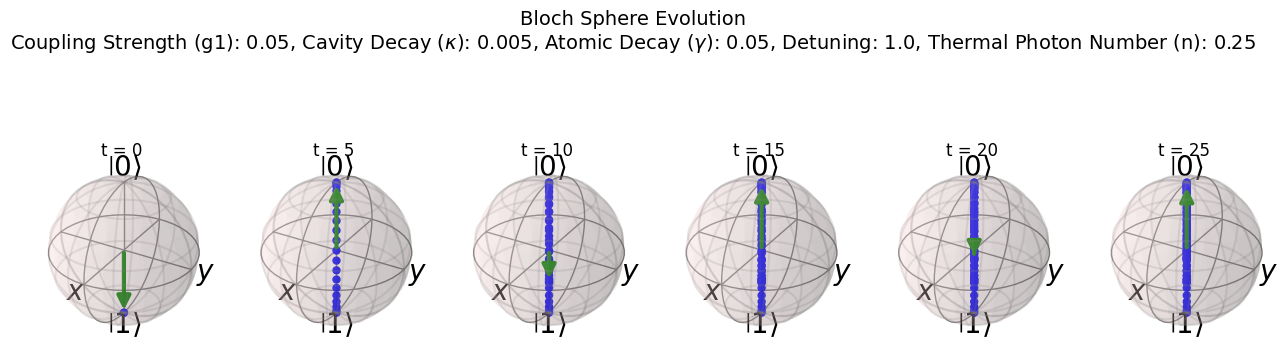

In [66]:
bloch_dynamics_snapshots(g1=0.05, kappa=0.005, gamma=0.05, detuning=1.0, n=0.25, N=15, timesteps=100)

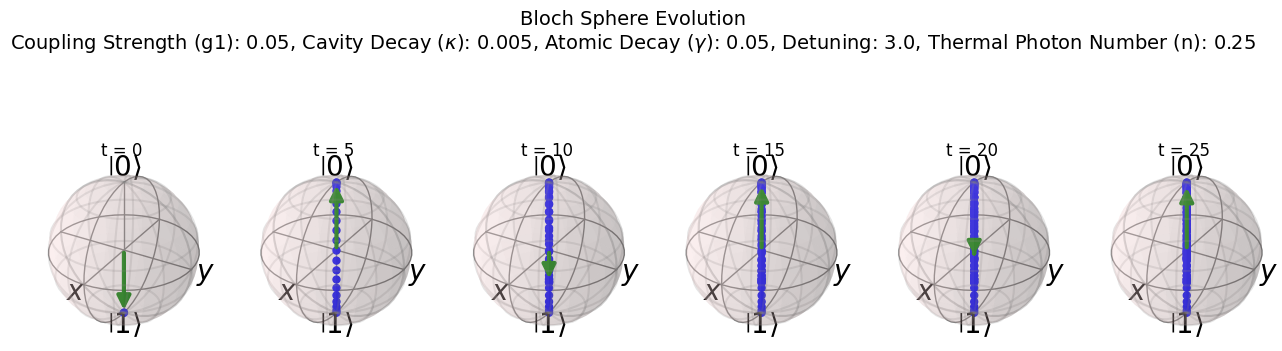

In [67]:
bloch_dynamics_snapshots(g1=0.05, kappa=0.005, gamma=0.05, detuning=3.0, n=0.25, N=15, timesteps=100)
